![Baseball Flights](baseball_flights.png)


To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling, and as such, we’ve got a few questions for you. 

Our primary areas of focus are surrounding the number of jets that The League needs to own, and the cost of fuel for those flights. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row, you’ll find information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but we're hoping you'll be able to project it to the future to help with the analysis.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

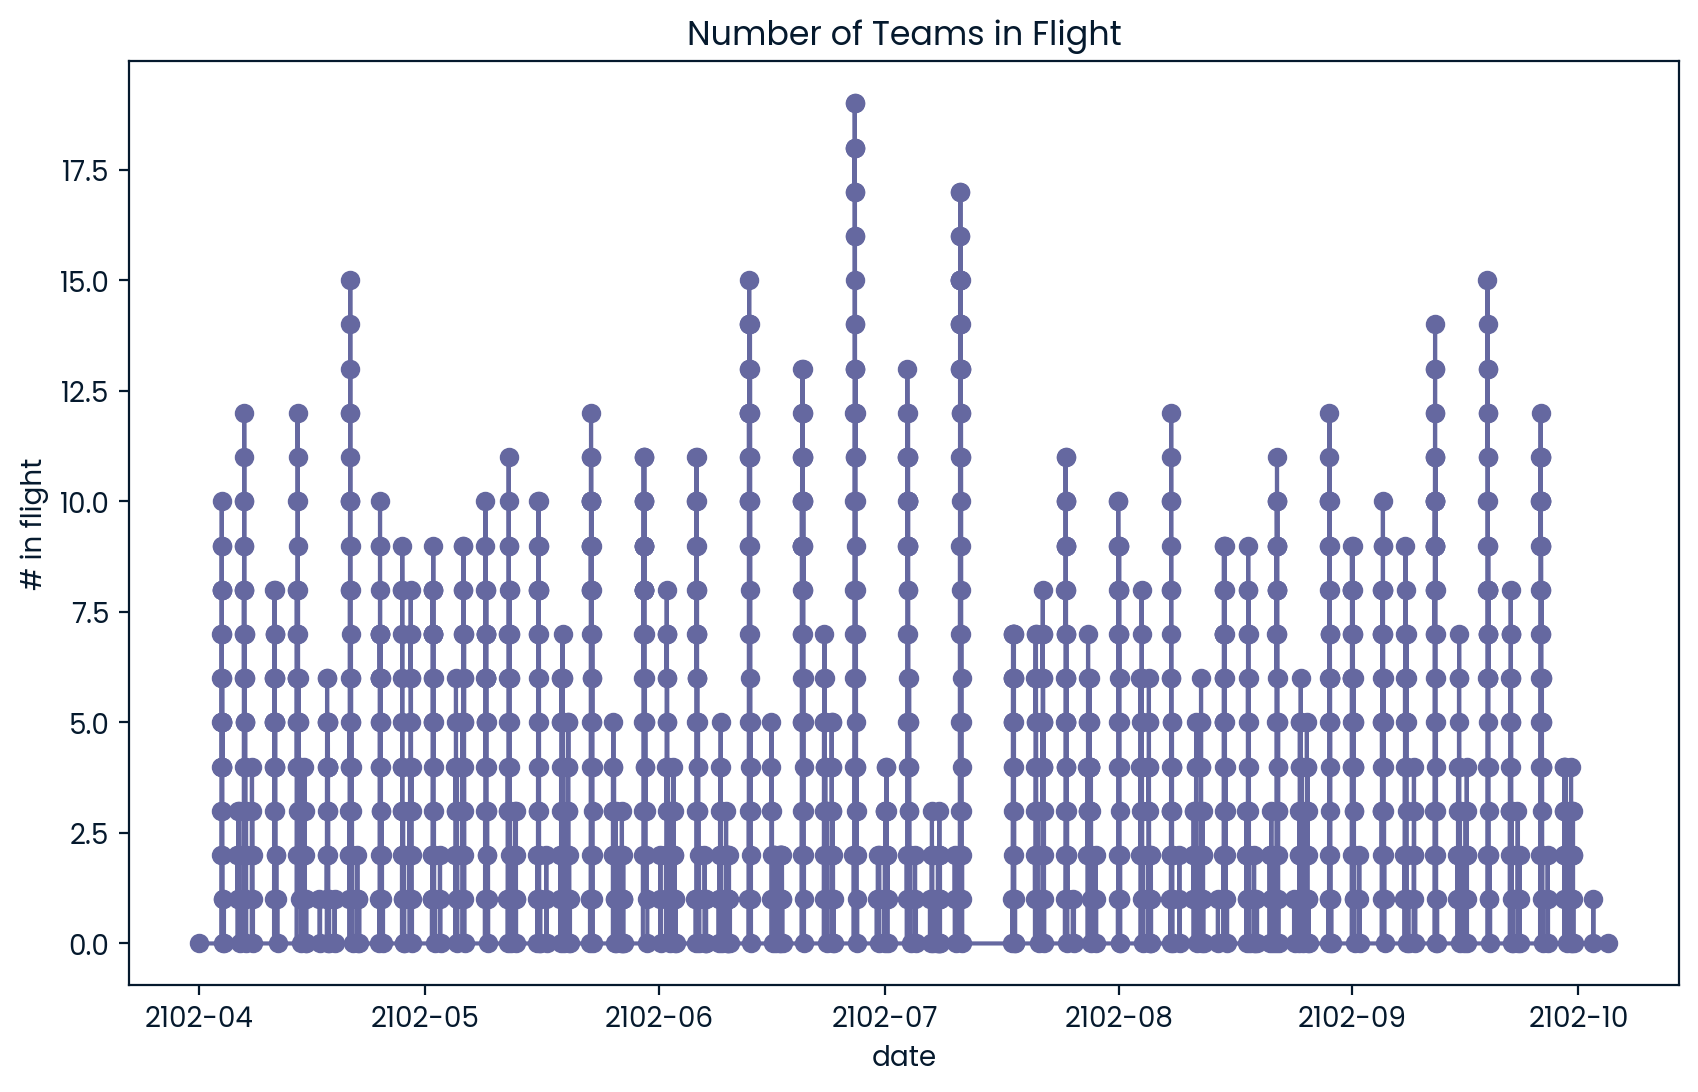

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64285D+00    |proj g|=  1.35965D+01

At iterate    5    f= -3.31348D+00    |proj g|=  3.58974D+00


 This problem is unconstrained.



At iterate   10    f= -3.37796D+00    |proj g|=  7.95253D+01

At iterate   15    f= -3.84508D+00    |proj g|=  6.77868D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   3.022D-01  -3.846D+00
  F =  -3.8457998516343048     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


1858731.3313757468

In [1]:
# Start coding here!
# raldisk
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Explore the data
team_flights = pd.read_csv('./team_flights.csv')
fuel_prices = pd.read_csv('./fuel_prices_2101.csv',
                         index_col='date')
team_flights.head()

# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

# 1. max_teams_in_flight
# First we'll want to know the minimum time between any two unique flight event times in the season
# To do this we first create a single array of times
all_datetimes = pd.concat([team_flights['departure_datetime'], team_flights['landing_datetime']])

# Sort the array of datetimes
all_datetimes_sorted = sorted(list(set(all_datetimes)))
all_datetimes_sorted.append(pd.to_datetime('2102-04-01 00:00:00')) #optional
all_datetimes_sorted.append(pd.to_datetime('2102-10-05 00:00:00')) #optional

# convert to data frame
in_flight_df = pd.DataFrame({'date':sorted(all_datetimes_sorted),
                             'in_flight':0})
# iterate through each known flight, and increment corresponding rows of in_flight_df
for index, flight in team_flights.iterrows():
    in_flight_df.loc[(in_flight_df['date']>=flight['departure_datetime']) &
                     (in_flight_df['date']<flight['landing_datetime']),'in_flight'] += 1

# Plot 
fig, ax = plt.subplots(figsize=(10, 6)) #optional size parameter
ax.step(in_flight_df['date'], in_flight_df['in_flight'], where='post') # optional
ax.scatter(in_flight_df['date'], in_flight_df['in_flight'])
ax.set_xlabel('date') # optional
ax.set_ylabel('# in flight') # optional
ax.set_title('Number of Teams in Flight') # optional
plt.show()

max_teams_in_flight = 19  # based on graph



# 2. total_fuel_spend_2102_dollars

# First we'll need to project fuel prices into 2102
# then we'll apply them to our flight info
# Fit Seasonal ARIMA model
model = SARIMAX(fuel_prices,
              order=(1, 1, 1),             # for linear growth term
              seasonal_order=(1, 0, 0, 7)  # for 7 day periodicity
              )
model_fit = model.fit()

# Forecast fuel prices for 2102
forecast = model_fit.get_forecast(steps=365)  # Forecast prices for 365 days in 2102

# Convert to Data Frame
fuel_prices_forecast = pd.DataFrame(data={"date": forecast.summary_frame().index.to_timestamp(), 
                                          "price":forecast.predicted_mean.values})

# Now we can apply to the flight data
# Step 1: Extract the date portion from the adjusted departure datetime
team_flights['departure_date'] = team_flights['departure_datetime'].dt.date

# Step 2: Join fuel_prices DataFrame based on the date
fuel_prices_forecast['date'] = fuel_prices_forecast['date'].dt.date
fuel_prices_forecast.set_index('date', inplace=True)
merged_df = team_flights.join(fuel_prices_forecast, on='departure_date', how='left')

# Step 3: Calculate the fuel cost for flights
# multiply price per mile
merged_df['fuel_cost_total'] = merged_df['price'] * merged_df['travel_distance_miles']

# Step 4: Calculate the overall fuel cost
total_fuel_spend_2102_dollars = merged_df['fuel_cost_total'].sum()
total_fuel_spend_2102_dollars